<a href="https://colab.research.google.com/github/sarthakc123/Sarthak_Vinit_ClimateRiskMitigationMCSim/blob/main/MCSim_ClimateRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, nbinom
from scipy.stats import gamma



In [2]:
df_New_Orleans = pd.read_csv('New_Orleans.csv')

df_New_Orleans.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,198911,15,1607,198911,15,1607,NaN,10045593,LOUISIANA,22.0,...,0.0,NaN,NaN,30.05,-90.03,NaN,NaN,NaN,NaN,PUB
1,198905,4,1750,198905,4,1750,NaN,10046667,LOUISIANA,22.0,...,0.0,NaN,NaN,30.05,-90.70,NaN,NaN,NaN,NaN,PUB
2,198905,4,1800,198905,4,1800,NaN,10046669,LOUISIANA,22.0,...,0.0,NaN,NaN,30.00,-90.48,NaN,NaN,NaN,NaN,PUB
3,198905,4,1815,198905,4,1815,NaN,10046670,LOUISIANA,22.0,...,0.0,NaN,NaN,30.00,-90.25,NaN,NaN,NaN,NaN,PUB
4,198905,4,1830,198905,4,1830,NaN,10046671,LOUISIANA,22.0,...,0.0,NaN,NaN,29.95,-90.10,NaN,NaN,NaN,NaN,PUB


In [3]:
df_New_Orleans['DAMAGE_PROPERTY'].sum()

np.float64(35468073000.0)

In [4]:
df_New_Orleans = df_New_Orleans[(df_New_Orleans['YEAR'] >= 1994) & (df_New_Orleans['YEAR'] <= 2024)]

In [5]:
df_New_Orleans.shape

(1191, 51)

# FUNCTION FOR FLOOD FREQUENCY IN A YEAR


In [6]:
# Count number of flood events per year
flood_frequency = df_New_Orleans.groupby('YEAR').size()

# Convert flood_frequency Series to DataFrame
df_floods = flood_frequency.reset_index()
df_floods.columns = ['Year', 'Floods']

# Sort by year just to be sure
df_floods = df_floods.sort_values('Year')

def simulate_flood_frequency(df_floods, n_years=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    mu = df_floods["Floods"].mean()
    var = df_floods["Floods"].var()

    if var > mu:
        p_nb = mu / var
        r_nb = mu**2 / (var - mu)
        dist = nbinom(r_nb, p_nb)
    else:
        dist = poisson(mu)

    if n_years is None:
        n_years = df_floods.shape[0]

    simulated_floods = dist.rvs(size=n_years)

    # Clamp to min=1 and max=mu + 7*σ
    lower = 1
    upper = int(mu + 7 * np.sqrt(var))
    return np.clip(simulated_floods, lower, upper)

simulated_counts = simulate_flood_frequency(df_floods, n_years=30)
print(simulated_counts)

[  9  21  16  28  17  51  49  27  38  43  10  48  37  31  23  13  13  50
  25  42  22  32 101  46  25  45  20  62  52  51]


# FUNCTION FOR FLOOD SEVERITY CALCULATION
Based on the damage caused by a flood during a

In [7]:
def assign_severity(df):
    # Define thresholds using quantiles
    q1 = 1_000_000
    q2 = 10_000_000
    q3 = 100_000_000

    def categorize(damage):
        if damage <= q1:
            return 'Low'
        elif damage <= q2:
            return 'Medium'
        elif damage <= q3:
            return 'High'
        else:
            return 'Extreme'

    df['SEVERITY_LEVEL'] = df['DAMAGE_PROPERTY'].apply(categorize)
    return df


df_New_Orleans = assign_severity(df_New_Orleans)

df_New_Orleans['SEVERITY_LEVEL'].value_counts()


,count
SEVERITY_LEVEL,
Low,1093
Medium,62
High,22
Extreme,14


In [8]:
# Define severity counts
severity_counts = {
    "Low": 1093,
    "Medium": 62,
    "High": 22,
    "Extreme": 14
}

# Calculate total and probabilities
total = sum(severity_counts.values())
severity_levels = list(severity_counts.keys())
probabilities = [count / total for count in severity_counts.values()]

# Function to generate random severity values based on distribution
def generate_random_severity(n=1):
    return np.random.choice(severity_levels, size=n, p=probabilities)

# Generate 30 random severities
print(generate_random_severity(30))

['Low' 'Low' 'High' 'Low' 'Low' 'Low' 'Low' 'Medium' 'Low' 'Low' 'Low'
 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low'
 'Low' 'Medium' 'Low' 'High' 'Low' 'Low' 'Low']


In [9]:
df = pd.read_csv("/content/SEA LEVEL RISE.csv")
#df_seadata.head()

df_louisiana_slr = df[
    (df['Latitude'] >= 28.5) & (df['Latitude'] <= 33.0) &
    ((df['Longitude'] <= -88.8) & (df['Longitude'] >= -94.0) |
     (df['Longitude'] >= 266.0) & (df['Longitude'] <= 271.2))  # For 0–360 longitude
]

columns_to_keep = [
    "Site",
    "PSMSL ID",
    "Latitude",
    "Longitude",
    "Scenario",
    "Background RSL rate (mm/yr)",
    "RSL in 2000 (cm)",
    "RSL in 2010 (cm)",
    "RSL in 2020 (cm)",
    "RSL in 2030 (cm)"
]

df_louisiana_slr = df_louisiana_slr[columns_to_keep]
#df_louisiana_slr["Site"].unique()
df_louisiana_slr=df_louisiana_slr.loc[df_louisiana_slr["Site"] == "GRAND ISLE"]
df_louisiana_slr.head()

# Filter for Grand Isle, 0.5 - MED scenario
row = df_louisiana_slr[df_louisiana_slr["Scenario"] == "0.5 - MED"].iloc[0]

# Step 1: Extract years and known SLR values
years_known = np.array([2000, 2010, 2020, 2030])
slr_known = np.array([
    row["RSL in 2000 (cm)"],
    row["RSL in 2010 (cm)"],
    row["RSL in 2020 (cm)"],
    row["RSL in 2030 (cm)"]
])

# Step 2: Predict for 2025–2054 using linear interpolation + extrapolation
years_future = np.arange(2025, 2055)
# Fit linear model
coeffs = np.polyfit(years_known, slr_known, deg=1)
slope, intercept = coeffs
slr_predicted = slope * years_future + intercept

print(slr_predicted)

[28.95 30.12 31.29 32.46 33.63 34.8  35.97 37.14 38.31 39.48 40.65 41.82
 42.99 44.16 45.33 46.5  47.67 48.84 50.01 51.18 52.35 53.52 54.69 55.86
 57.03 58.2  59.37 60.54 61.71 62.88]


In [10]:
def generate_random_slr(n=1):
    return slr_predicted[:30]

In [21]:
# Load and filter dataset
df = pd.read_csv("4012474.csv")
prcp_values = df["PRCP"].dropna()

# Fit Gamma distribution to historical precipitation data
shape, loc, scale = gamma.fit(prcp_values)

# Function to generate n simulated precipitation values
def generate_random_precipitation(n=1, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    return gamma.rvs(shape, loc=loc, scale=scale, size=n)



In [12]:
alpha = 1000000
beta = 1.25
gamma_1 = 0.01

def simulate_average_flood_damage(n_iterations=1000, m_years=30, alpha=alpha, beta=beta, gamma_scale=gamma_1, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    total_damage = 0

    # Map severity levels to numeric factors
    severity_map = {"Low": 1, "Medium": 2, "High": 3, "Extreme": 4}

    for _ in range(n_iterations):
        # Step 1: Simulate flood frequency for each year
        flood_counts = simulate_flood_frequency(df_floods, n_years=m_years)

        # Step 2: Generate SLR and Precipitation values for each year
        slr_values = generate_random_slr(m_years)
        prcp_values = generate_random_precipitation(m_years)

        damage_sum = 0

        for year in range(m_years):
            floods_this_year = flood_counts[year]
            slr = slr_values[year]
            prcp = prcp_values[year]

            # Step 3: Assign severity for each flood
            severities = generate_random_severity(floods_this_year)

            # Step 4: Compute damage per flood and sum
            for sev in severities:
                severity_factor = severity_map[sev]
                damage = alpha * severity_factor * (1 + beta * slr) * (1 + gamma_scale * prcp)
                damage_sum += damage


        total_damage += damage_sum

    # Step 5: Return average damage over all iterations
    average_damage = total_damage / n_iterations
    return average_damage

In [13]:
# Load dataset
df = pd.read_csv("/content/HazardMitigationAssistanceProjects.csv")

# Clean and filter for Louisiana
df['projectType_clean'] = df['projectType'].astype(str).str.lower()
df['dateApproved'] = pd.to_datetime(df['dateApproved'], errors='coerce')

# Filter for Louisiana and years 2020–2025
keep_cols = [
    'projectIdentifier', 'state', 'county', 'projectType', 'status',
    'dateApproved', 'projectAmount', 'federalShareObligated', 'benefitCostRatio',
    'numberOfProperties', 'netValueBenefits', 'costSharePercentage', 'projectType_clean'
]
df = df[(df['state'] == 'Louisiana') &
        (df['dateApproved'].dt.year >= 2020) &
        (df['dateApproved'].dt.year <= 2025)][keep_cols] #Assuming it is not implemented still started after 2020

# Disaster-related keywords
keywords = ['flood', 'floodwater', 'coastal', 'hurricane', 'stormwater', 'levee',
            'drainage', 'sea', 'level', 'elevation', 'floodproof', 'wind', 'tornado']
df = df[df['projectType_clean'].apply(lambda x: any(kw in x for kw in keywords))]

# Categorize mitigation types
def categorize(ptype):
    ptype = ptype.lower()
    if "acquisition" in ptype:
        return "Property Acquisition"
    elif "elevation" in ptype:
        return "Elevation"
    elif "relocation" in ptype:
        return "Relocation"
    elif "retrofit" in ptype:
        return "Structural Retrofitting"
    elif "stormwater" in ptype or "culvert" in ptype or "drainage" in ptype:
        return "Stormwater Management"
    elif "levee" in ptype or "floodwall" in ptype:
        return "Structural Flood Control"
    elif "natural" in ptype or "green" in ptype or "ecosystem" in ptype:
        return "Natural Infrastructure"
    elif "floodproof" in ptype:
        return "Floodproofing"
    else:
        return "Other / Misc"

df['mitigationCategory'] = df['projectType'].apply(categorize)

# Group by category
summary = df.groupby('mitigationCategory').agg({
    'projectAmount': 'sum',
    'benefitCostRatio': 'mean'
}).reset_index()

# Normalize BCR for weight and reduction factor
summary['weight'] = summary['benefitCostRatio'] / summary['benefitCostRatio'].sum()
summary['reduction_factor'] = summary['weight']

# Final DataFrame
final_df = summary[['mitigationCategory', 'projectAmount', 'benefitCostRatio','weight']]

# Display
final_df

,mitigationCategory,projectAmount,benefitCostRatio,weight
0,Elevation,1.139937e+09,2.139652,0.092675
1,Floodproofing,1.164000e+05,5.965000,0.258361
2,Other / Misc,2.584998e+08,3.874464,0.167814
3,Property Acquisition,1.373596e+08,1.706923,0.073932
4,Stormwater Management,4.592656e+08,1.973441,0.085475
5,Structural Flood Control,1.556066e+07,5.698571,0.246822
6,Structural Retrofitting,6.342577e+07,1.729767,0.074921


**Hypothesis 1:-**

In [80]:
import numpy as np

# Helper: Randomly select 1 to 6 mitigation types and apply compounding reduction
def get_multiple_mitigation_reduction(min_strategies=1, max_strategies=6):
    weights = np.array([0.092675, 0.258361, 0.167814, 0.073932, 0.085475, 0.246822, 0.074921])
    n = np.random.randint(min_strategies, max_strategies + 1)
    selected_indices = np.random.choice(len(weights), size=n, replace=False)
    combined_reduction = 1 - np.prod([1 - weights[i] for i in selected_indices])  # compounded impact
    return combined_reduction

# Modified simulation function to apply multiple mitigation strategies
def simulate_average_flood_damage_with_mitigation_multiple_strategies(
    n_iterations=1000,
    m_years=30,
    alpha=1000000,
    beta=1.25,
    gamma_scale=0.01,
    min_strategies=1,
    max_strategies=6
):
    severity_map = {"Low": 1, "Medium": 2, "High": 3, "Extreme": 4}
    total_damage = 0

    for _ in range(n_iterations):
        flood_counts = simulate_flood_frequency(df_floods, n_years=m_years)
        slr_values = generate_random_slr(m_years)
        prcp_values = generate_random_precipitation(m_years)

        damage_sum = 0
        for year in range(m_years):
            floods_this_year = flood_counts[year]
            slr = slr_values[year]
            prcp = prcp_values[year]

            severities = generate_random_severity(floods_this_year)
            reduction_factor = get_multiple_mitigation_reduction(min_strategies, max_strategies)

            for sev in severities:
                severity_factor = severity_map[sev]
                raw_damage = alpha * severity_factor * (1 + beta * slr) * (1 + gamma_scale * prcp)
                adjusted_damage = raw_damage * (1 - reduction_factor)
                damage_sum += adjusted_damage

        total_damage += damage_sum

    average_damage = total_damage / n_iterations
    return average_damage

In [81]:
years = 30
avg_damage = simulate_average_flood_damage(n_iterations=1000, m_years=years)
print(f"Estimated Total Damage over {years} years: ${avg_damage:,.2f}")

Estimated Total Damage over 30 years: $1,106,298,633,152.63


In [82]:
avg_damage_mitigated = simulate_average_flood_damage_with_mitigation_multiple_strategies(n_iterations=1000, m_years=years)
print(f"Estimated Total Damage over {years} years with Mitigation: ${avg_damage_mitigated:,.2f}")

Estimated Total Damage over 30 years with Mitigation: $657,686,658,295.89


In [83]:
percentage_1=((avg_damage-avg_damage_mitigated)/avg_damage_mitigated)*100
print(percentage_1)

68.21059378323471


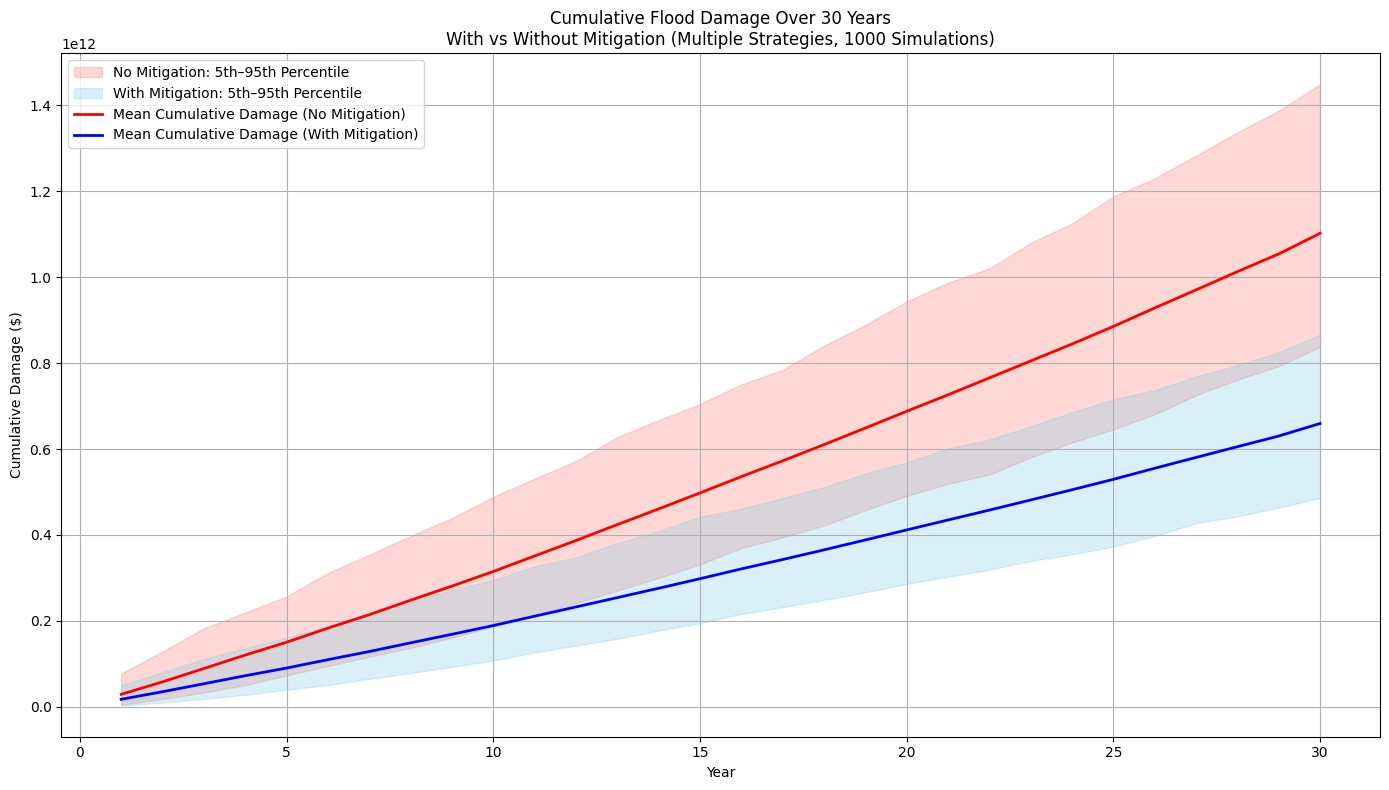

In [89]:
# Function to simulate yearly damage for both scenarios
def run_yearly_damage_simulations(n_iterations=1000, m_years=30, alpha=1_000_000, beta=1.25, gamma_scale=0.01):
    severity_map = {"Low": 1, "Medium": 2, "High": 3, "Extreme": 4}

    all_damage_no_mitigation = []
    all_damage_with_mitigation = []

    for _ in range(n_iterations):
        flood_counts = simulate_flood_frequency(df_floods, n_years=m_years)
        slr_values = generate_random_slr(m_years)
        prcp_values = generate_random_precipitation(m_years)

        yearly_damage_no_mit = []
        yearly_damage_with_mit = []

        for year in range(m_years):
            floods_this_year = flood_counts[year]
            slr = slr_values[year]
            prcp = prcp_values[year]
            severities = generate_random_severity(floods_this_year)

            reduction_factor = get_multiple_mitigation_reduction()  # Updated here

            dmg_no_mit = 0
            dmg_with_mit = 0

            for sev in severities:
                sev_factor = severity_map[sev]
                raw_dmg = alpha * sev_factor * (1 + beta * slr) * (1 + gamma_scale * prcp)
                dmg_no_mit += raw_dmg
                dmg_with_mit += raw_dmg * (1 - reduction_factor)

            yearly_damage_no_mit.append(dmg_no_mit)
            yearly_damage_with_mit.append(dmg_with_mit)

        all_damage_no_mitigation.append(yearly_damage_no_mit)
        all_damage_with_mitigation.append(yearly_damage_with_mit)

    return np.array(all_damage_no_mitigation), np.array(all_damage_with_mitigation)


# Run simulations
damage_no_mit, damage_with_mit = run_yearly_damage_simulations(n_iterations=1000, m_years=30)

# Cumulative damage
damage_cum_no_mit = np.cumsum(damage_no_mit, axis=1)
damage_cum_with_mit = np.cumsum(damage_with_mit, axis=1)

# Stats
mean_no_mit = np.mean(damage_cum_no_mit, axis=0)
mean_with_mit = np.mean(damage_cum_with_mit, axis=0)

p5_no_mit = np.percentile(damage_cum_no_mit, 5, axis=0)
p95_no_mit = np.percentile(damage_cum_no_mit, 95, axis=0)

p5_with_mit = np.percentile(damage_cum_with_mit, 5, axis=0)
p95_with_mit = np.percentile(damage_cum_with_mit, 95, axis=0)

# Plot
plt.figure(figsize=(14, 8))
x = range(1, 31)

plt.fill_between(x, p5_no_mit, p95_no_mit, color='salmon', alpha=0.3, label='No Mitigation: 5th–95th Percentile')
plt.fill_between(x, p5_with_mit, p95_with_mit, color='skyblue', alpha=0.3, label='With Mitigation: 5th–95th Percentile')

plt.plot(x, mean_no_mit, color='red', linewidth=2, label='Mean Cumulative Damage (No Mitigation)')
plt.plot(x, mean_with_mit, color='blue', linewidth=2, label='Mean Cumulative Damage (With Mitigation)')

plt.title('Cumulative Flood Damage Over 30 Years\nWith vs Without Mitigation (Multiple Strategies, 1000 Simulations)')
plt.xlabel('Year')
plt.ylabel('Cumulative Damage ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

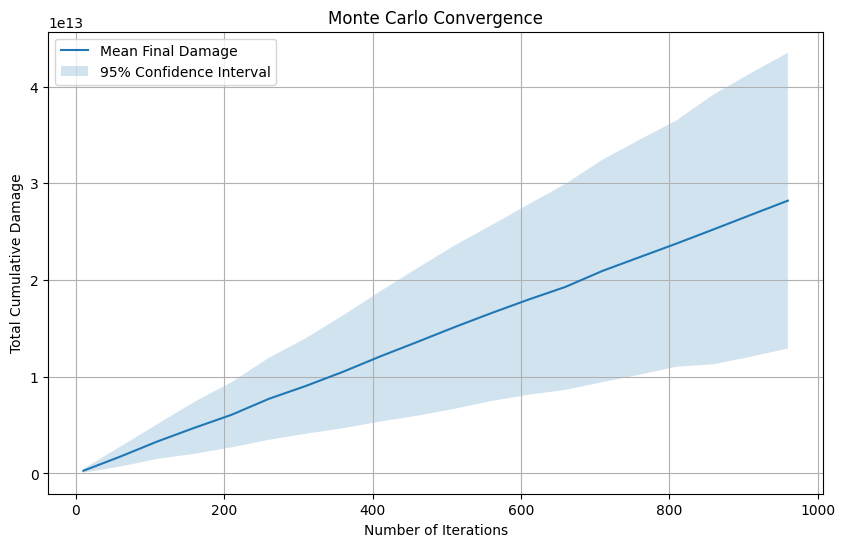

In [90]:
# Convergence plot
means = []
stdevs = []
n = 1000
for n in range(10, n+1, 50):  # simulate from 10 to 1000 iterations
    matrix = run_yearly_damage_simulations(n_iterations=n, m_years=30)
    final_damage = np.cumsum(matrix, axis=1)[:, -1]  # total cumulative damage
    means.append(np.mean(final_damage))
    stdevs.append(np.std(final_damage))

plt.figure(figsize=(10, 6))
plt.plot(range(10, n+1, 50), means, label='Mean Final Damage')
plt.fill_between(range(10, n+1, 50),
                 np.array(means) - 1.96 * np.array(stdevs),
                 np.array(means) + 1.96 * np.array(stdevs),
                 alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Number of Iterations')
plt.ylabel('Total Cumulative Damage')
plt.title('Monte Carlo Convergence')
plt.legend()
plt.grid(True)
plt.show()


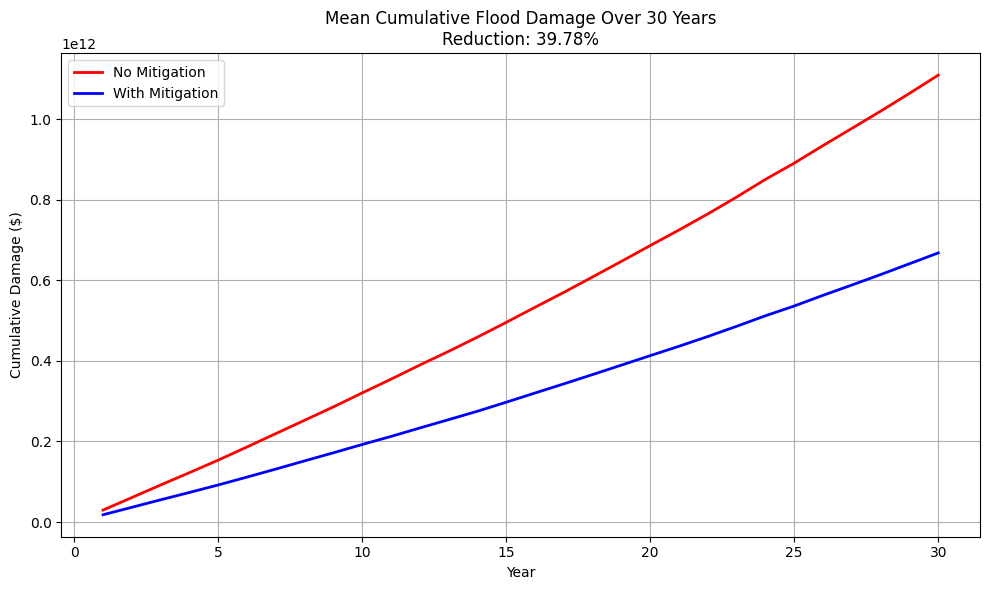

In [87]:
# Step 1: Ensure cumulative arrays exist
damage_cum_no_mit = np.cumsum(damage_no_mit, axis=1)
damage_cum_with_mit = np.cumsum(damage_with_mit, axis=1)

# Step 2: Hypothesis 1 – 40% or more reduction in mean cumulative damage
mean_total_no_mit = damage_cum_no_mit[:, -1].mean()
mean_total_with_mit = damage_cum_with_mit[:, -1].mean()
reduction_percent = (mean_total_no_mit - mean_total_with_mit) / mean_total_no_mit * 100

# Plot the mean cumulative damage for both scenarios
plt.figure(figsize=(10, 6))
x = range(1, 31)

plt.plot(x, damage_cum_no_mit.mean(axis=0), label="No Mitigation", color='red', linewidth=2)
plt.plot(x, damage_cum_with_mit.mean(axis=0), label="With Mitigation", color='blue', linewidth=2)

plt.title(f"Mean Cumulative Flood Damage Over 30 Years\nReduction: {reduction_percent:.2f}%")
plt.xlabel("Year")
plt.ylabel("Cumulative Damage ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [97]:
import numpy as np

# 1. Simulate mitigation investments realistically
def simulate_investment_mitigation_monte_carlo_multiple(final_df, n_iterations=1000, m_years=30, growth_rate=0.10, min_strategies=1, max_strategies=6):
    total_investments = []
    weights = final_df["weight"].values
    categories = final_df["mitigationCategory"].values

    for _ in range(n_iterations):
        selected_index = np.random.choice(len(categories), p=weights)
        project_amount = final_df.loc[selected_index, "projectAmount"]
        bcr = final_df.loc[selected_index, "benefitCostRatio"]

        # Adjust for number of strategies (same logic as in damage)
        num_strategies = np.random.randint(min_strategies, max_strategies + 1)
        investment = (project_amount / bcr) * num_strategies

        growth_factors = np.array([(1 + growth_rate) ** i for i in range(m_years)])
        base_annual_cost = investment / growth_factors.sum()
        annual_costs = base_annual_cost * growth_factors
        cumulative_cost = annual_costs.sum()

        total_investments.append(cumulative_cost)

    return np.array(total_investments)

# 2. Run investment simulation
mitigation_investments = simulate_investment_mitigation_monte_carlo_multiple(
    final_df, n_iterations=1000, min_strategies=1, max_strategies=6
)

# 3. Calculate average damage avoided
damage_avoided = damage_no_mit - damage_with_mit
cumulative_damage_avoided = np.cumsum(damage_avoided, axis=1)
mean_damage_avoided = cumulative_damage_avoided[:, -1].mean()  # ✅ fixed

# 4. Compute average investment
mean_investment = mitigation_investments.mean()

# 5. ROI
mean_cumulative_roi = mean_damage_avoided / mean_investment
break_even = mean_damage_avoided >= mean_investment

# 6. Print result
print("\n💡 System-Level Hypothesis Validation (Mean per Simulation):")
print(f"✅ Mean Investment per Simulation: ${mean_investment:,.0f}")
print(f"✅ Mean Benefit per Simulation (Damage Avoided): ${mean_damage_avoided:,.0f}")
print(f"✅ For every $1 invested, ${mean_cumulative_roi:.2f} was saved in avoided damage.")
print(f"✅ Break-Even Achieved: {'Yes' if break_even else 'No'}")


💡 System-Level Hypothesis Validation (Mean per Simulation):
✅ Mean Investment per Simulation: $364,887,889
✅ Mean Benefit per Simulation (Damage Avoided): $442,751,982,829
✅ For every $1 invested, $1213.39 was saved in avoided damage.
✅ Break-Even Achieved: Yes


In [102]:
# Monte Carlo-style break-even analysis with actual multiple mitigation investment structure

# Step 1: Calculate damage avoided and cumulative cost over time
damage_avoided = damage_no_mit - damage_with_mit
cumulative_damage_avoided = np.cumsum(damage_avoided, axis=1)

# Step 2: Investment growth model
years = 30
growth_rate = 0.10
growth_factors = np.array([(1 + growth_rate) ** i for i in range(years)])
base_costs = mitigation_investments / growth_factors.sum()
annual_costs_matrix = base_costs[:, np.newaxis] * growth_factors
cumulative_costs_matrix = np.cumsum(annual_costs_matrix, axis=1)

# Step 3: Breakeven check
breakeven_matrix = cumulative_damage_avoided >= cumulative_costs_matrix
breakeven_achieved_by_30 = breakeven_matrix[:, -1]  # Boolean array

# Step 4: Summary statistics
percent_breakeven = breakeven_achieved_by_30.mean() * 100

# Step 5: Print result
print("\n💡 Hypothesis Check: At least 70% of simulations break even within 30 years")
print(f"✅ Proportion of simulations that broke even by Year 30: {percent_breakeven:.1f}%")

if percent_breakeven >= 70:
    print("✅ Hypothesis PASSED: At least 70% reached break-even.")
else:
    print("❌ Hypothesis FAILED: Fewer than 70% reached break-even.")


💡 Hypothesis Check: At least 70% of simulations break even within 30 years
✅ Proportion of simulations that broke even by Year 30: 100.0%
✅ Hypothesis PASSED: At least 70% reached break-even.


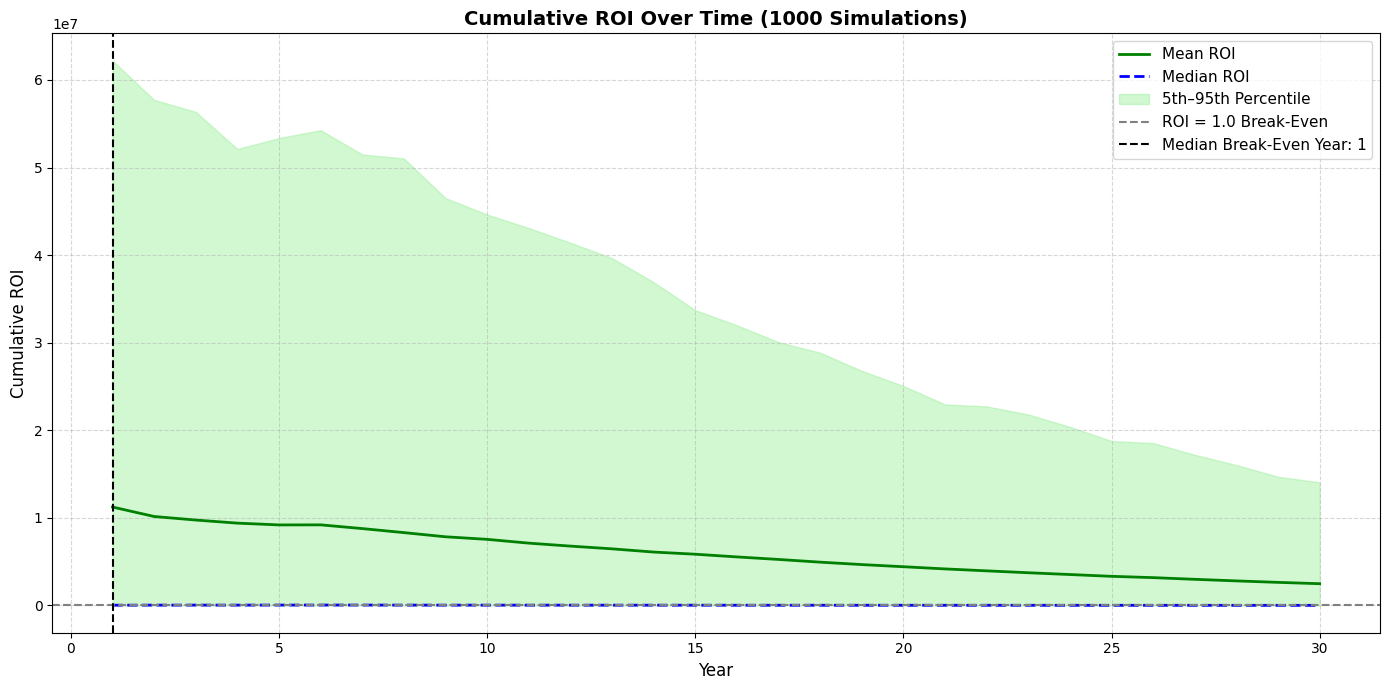


📊 Final ROI Summary:
📍 Median Break-Even Year: Year 1
💵 Median Investment per Simulation: $36,667,233


In [107]:
# === FINAL ROI ANALYSIS CODE WITH MEAN, MEDIAN ROI, AND MEDIAN INVESTMENT ===

import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate cumulative ROI per simulation over time
roi_time_series = cumulative_damage_avoided / cumulative_costs_matrix

# Step 2: Median break-even year (first year when ROI ≥ 1.0)
breakeven_years = np.argmax(roi_time_series >= 1.0, axis=1).astype(float) + 1
breakeven_years[~roi_time_series.any(axis=1)] = np.nan
median_breakeven_year = int(np.nanmedian(breakeven_years))

# Step 3: Mean and median ROI across all simulations
mean_roi = roi_time_series.mean(axis=0)
median_roi = np.median(roi_time_series, axis=0)
p5_roi = np.percentile(roi_time_series, 5, axis=0)
p95_roi = np.percentile(roi_time_series, 95, axis=0)

# Step 4: Median investment
median_investment = np.median(mitigation_investments)

# Step 5: Plot ROI chart
x = np.arange(1, 31)
plt.figure(figsize=(14, 7))
plt.plot(x, mean_roi, label='Mean ROI', color='green', linewidth=2)
plt.plot(x, median_roi, label='Median ROI', color='blue', linestyle='--', linewidth=2)
plt.fill_between(x, p5_roi, p95_roi, color='lightgreen', alpha=0.4, label='5th–95th Percentile')
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1.5, label='ROI = 1.0 Break-Even')
plt.axvline(median_breakeven_year, color='black', linestyle='--', linewidth=1.5, label=f'Median Break-Even Year: {median_breakeven_year}')

# Style
plt.title('Cumulative ROI Over Time (1000 Simulations)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative ROI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Step 6: Print Key Summary Stats
print("\n📊 Final ROI Summary:")
print(f"📍 Median Break-Even Year: Year {median_breakeven_year}")
print(f"💵 Median Investment per Simulation: ${median_investment:,.0f}")

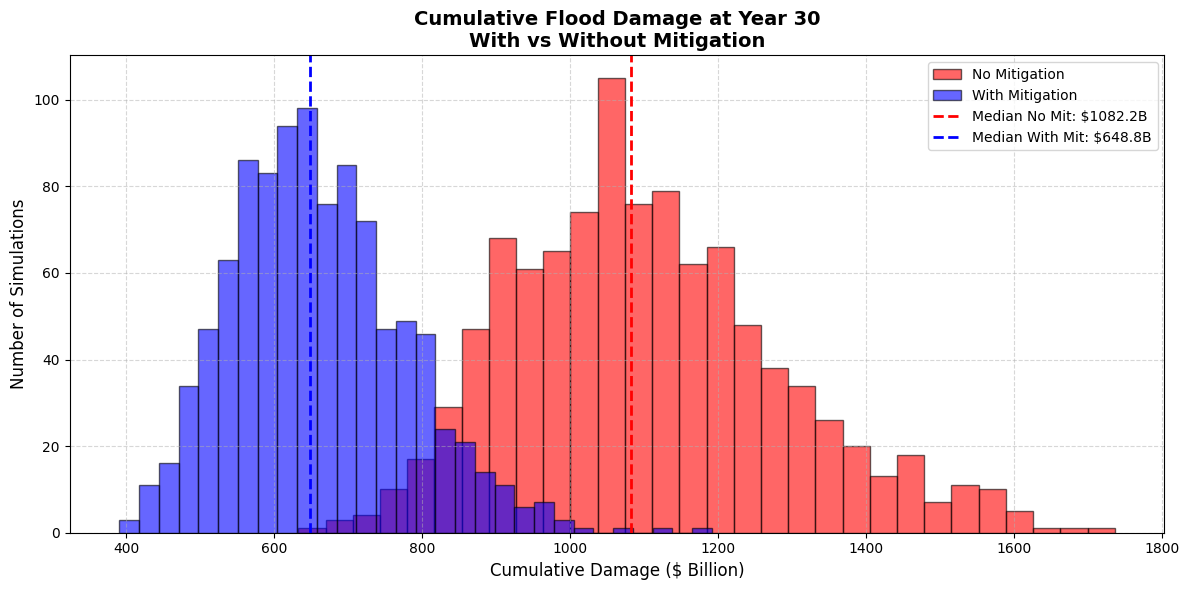


💡 Final Summary (Medians at Year 30):
🟥 Median Damage (No Mitigation):    $1,082,180,409,153
🟦 Median Damage (With Mitigation):  $648,784,185,116
📉 Absolute Reduction:               $433,396,224,038
📉 Percent Reduction:                40.05%


In [105]:
import numpy as np
import matplotlib.pyplot as plt

# === FINAL ANALYSIS CODE: Cumulative Damage Comparison ===

# Step 1: Calculate cumulative damage at Year 30 for both scenarios
cumulative_no_mit = np.cumsum(damage_no_mit, axis=1)
cumulative_with_mit = np.cumsum(damage_with_mit, axis=1)
final_damage_no_mit = cumulative_no_mit[:, -1]
final_damage_with_mit = cumulative_with_mit[:, -1]

# Step 2: Compute median values
median_no_mit = np.median(final_damage_no_mit)
median_with_mit = np.median(final_damage_with_mit)

# Step 3: Calculate differences
absolute_difference = median_no_mit - median_with_mit
percent_reduction = (absolute_difference / median_no_mit) * 100

# Step 4: Plot histograms with median lines
plt.figure(figsize=(12, 6))
plt.hist(final_damage_no_mit / 1e9, bins=30, alpha=0.6, label='No Mitigation', color='red', edgecolor='black')
plt.hist(final_damage_with_mit / 1e9, bins=30, alpha=0.6, label='With Mitigation', color='blue', edgecolor='black')

# Add vertical lines for medians
plt.axvline(median_no_mit / 1e9, color='red', linestyle='--', linewidth=2, label=f'Median No Mit: ${median_no_mit/1e9:.1f}B')
plt.axvline(median_with_mit / 1e9, color='blue', linestyle='--', linewidth=2, label=f'Median With Mit: ${median_with_mit/1e9:.1f}B')

# Chart formatting
plt.title('Cumulative Flood Damage at Year 30\nWith vs Without Mitigation', fontsize=14, weight='bold')
plt.xlabel('Cumulative Damage ($ Billion)', fontsize=12)
plt.ylabel('Number of Simulations', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Step 5: Print summary statistics
print("\n💡 Final Summary (Medians at Year 30):")
print(f"🟥 Median Damage (No Mitigation):    ${median_no_mit:,.0f}")
print(f"🟦 Median Damage (With Mitigation):  ${median_with_mit:,.0f}")
print(f"📉 Absolute Reduction:               ${absolute_difference:,.0f}")
print(f"📉 Percent Reduction:                {percent_reduction:.2f}%")